In [254]:
from typing import Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from lightning import Trainer
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

from shared import overwrite_args_cli
from shared.loss import Loss
from shared.model import Classifier
from shared.transformations import create_multiple_views
from shared.transformations import subsample_with_random_transform
from shared.data.data_loader import data_loaders

torch.set_float32_matmul_precision('medium')

h = {  # hyperparameters
    'dataset': 'MNIST',  #'TOY_REGRESSION', 'RADIO',
    'dataset_path': '../data/',

    'num_views': 5,
    # 'loss': 'cross_entropy',  # 'cross_entropy', 'cross_entropy_with_distinct_path_regularization',
    'alpha': 1, #0.35 seems to kinda work w/ acc 0.9,  # 1 for cross_entropy, 0 for distinct_path_regularization

    'in_channels': 1,
    'latent_dims': [32, 64],
    'latent_strides': [2, 2],
    'latent_kernel_sizes': [3, 3],
    'num_classes': 10,

    'epochs': 2,
    'learning_rate': 1e-3,
    'checkpoint_path': './saved_models',
    'batch_size': 32,
    'num_workers': 4,

    'limit_train_batches': 1.0,
    'limit_val_batches': 1.0,
    'limit_test_batches': 1.0,

    'use_wandb': False,

    'wandb_project': 'uncertainty',
    'wandb_entity': 'oBoii',
    'wandb_name': 'radio',

    'train': True,  # Set this to false if you only want to evaluate the model
    'fast_dev_run': False,
    'overfit_batches': 0.0
}

h = overwrite_args_cli(h)
# assert h['loss'] in ['cross_entropy', 'cross_entropy_with_distinct_path_regularization']

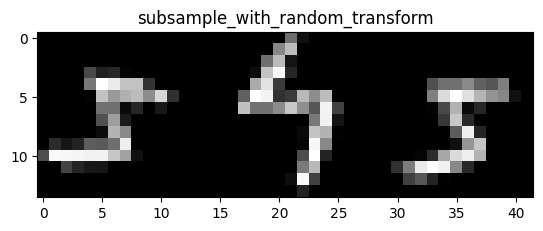

In [255]:
def show_transformations():
    # dispay the different subsampling methods, same image repeated 3 times
    transform = transforms.Compose([transforms.ToTensor()])  #rnd_subsample_method])
    mnist_train = MNIST(h['dataset_path'], train=True, download=True, transform=transform)

    methods = [
        # subsample,
        #        subsample_with_random_stride,
        #        subsample_with_patch_dropout,
        subsample_with_random_transform,
        # subsample_with_pixel_swapping
    ]
    x, y = mnist_train[0]
    for method in methods:
        # create 3 images and display them side by side
        imgs = [method(x) for _ in range(3)]
        imgs = torch.cat(imgs, dim=2)
        plt.imshow(imgs.squeeze(0), cmap='gray')
        plt.title(method.__name__)
        plt.show()


show_transformations()

In [256]:
train_loader, val_loader = data_loaders(
    h,
    [lambda _: create_multiple_views(_, h['num_views'], subsample_with_random_transform)])

c = Classifier(
    h=h,
    in_channels=h['in_channels'],
    latent_dims=h['latent_dims'],
    latent_strides=h['latent_strides'],
    latent_kernel_sizes=h['latent_kernel_sizes'],
    num_classes=h['num_classes'],
    loss=Loss(h['alpha'])
)

trainer = Trainer(max_epochs=h['epochs'], fast_dev_run=h['fast_dev_run'], overfit_batches=h['overfit_batches'])

if h['train']:
    trainer.fit(c, train_loader, val_loader)

# Evaluate the model
results = trainer.test(c, val_loader)

# Print accuracy
print(f"Test Accuracy: {results[0]['test_acc']:.4f}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | loss   | Loss       | 0     
1 | layers | ModuleList | 19.0 K
2 | fc     | Linear     | 650   
--------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.935699999332428     │
└───────────────────────────┴───────────────────────────┘

Test Accuracy: 0.9357


In [257]:
def _variances_vs_accuracy_per_input_img(classifier: Classifier, batch: Tuple[Tensor, Tensor]) -> Tensor:
    """Returns tensor of shape (batch, 2),
    where the first column is the variance and the second column
    is 1 or 0 if the prediction is correct or not."""

    x, y = batch
    assert x.dim() == 5  # (batch, nb_views, C, H, W)

    # 1) per view, compute the predictions
    predictions, _ = classifier.forward_multiple(x)  # (batch_size, num_views, num_classes)
    assert len(predictions.shape) == 3, f"Predictions shape is {predictions.shape}, expected 3 dimensions."

    # softmax the predictions
    predictions = F.softmax(predictions, dim=2)  # (batch_size, num_views, num_classes)

    # 2) compute the variance of the predictions
    variance = predictions.var(dim=1)  # (batch_size, num_classes)
    average_variance = variance.mean(dim=1)  # (batch_size)

    # 3) get mean of the predictions and take argmax
    final_predictions = predictions.mean(dim=1).argmax(dim=1)  # (batch_size)

    # 4) compute the accuracy of the mode with the labels
    accuracy = (final_predictions == y)  # (batch_size)

    # 5) stack the variance and accuracy
    stack = torch.stack((average_variance, accuracy), dim=1)  # (batch_size, 2)
    return stack


def variances_vs_accuracy_per_input_img(classifier: Classifier, data_loader: DataLoader) -> Tensor:
    """Returns tensor of shape (batch, 2),
    where the first column is the variance and the second column
    is 1 or 0 if the prediction is correct or not."""

    classifier.eval()
    var_vs_accuracy = None
    for batch in data_loader:
        batch_var_vs_accuracy = _variances_vs_accuracy_per_input_img(classifier, batch)
        if var_vs_accuracy is None:
            var_vs_accuracy = batch_var_vs_accuracy
        else:
            var_vs_accuracy = torch.cat((var_vs_accuracy, batch_var_vs_accuracy), dim=0)

    return var_vs_accuracy


c.eval()
train, val = data_loaders(h, [lambda _: create_multiple_views(_, h['num_views'], subsample_with_random_transform)])
# (batch_size, 2) where 1st column is variance and 2nd is 1 or 0 if the prediction is correct or not
res = variances_vs_accuracy_per_input_img(c, val)
print(res.shape)

torch.Size([10000, 2])


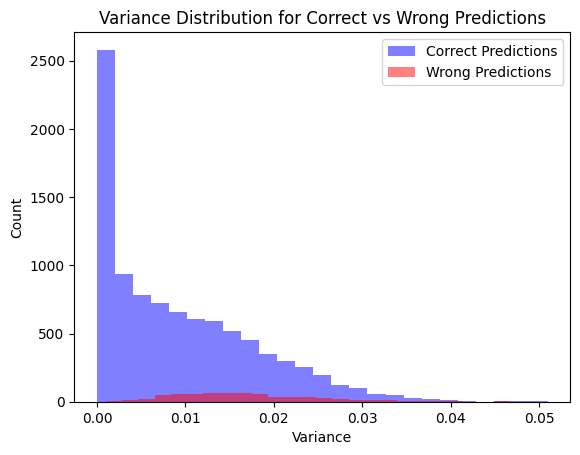

In [258]:
def distribution_variances_per_wrong_or_correct_prediction(var_vs_accuracy: Tensor):
    variances = var_vs_accuracy[:, 0].numpy()  # scalar values
    accuracies = var_vs_accuracy[:, 1].numpy()  # 0 or 1s

    fig, ax = plt.subplots()
    colors = ['blue', 'red']  # Colors for correct and wrong predictions
    labels = ['Correct Predictions', 'Wrong Predictions']

    for i, use_correct_predictions in enumerate([1., 0.]):
        indices = np.where(accuracies == use_correct_predictions)[0]
        variances_filtered = variances[indices]
        ax.hist(variances_filtered, bins=25, color=colors[i], alpha=0.5, label=labels[i])

    ax.set_xlabel("Variance")
    ax.set_ylabel("Count")
    ax.set_title("Variance Distribution for Correct vs Wrong Predictions")
    ax.legend()

    # Log the matplotlib figure to wandb
    # if options.use_wandb:
    #     wandb_section = get_wandb_audio_classific_key(opt, classifier_config)
    #     wandb.log({f"{wandb_section}_softmax/variance_distribution_combined": wandb.Image(fig)})

    plt.show()
    plt.close(fig)


distribution_variances_per_wrong_or_correct_prediction(res.detach())

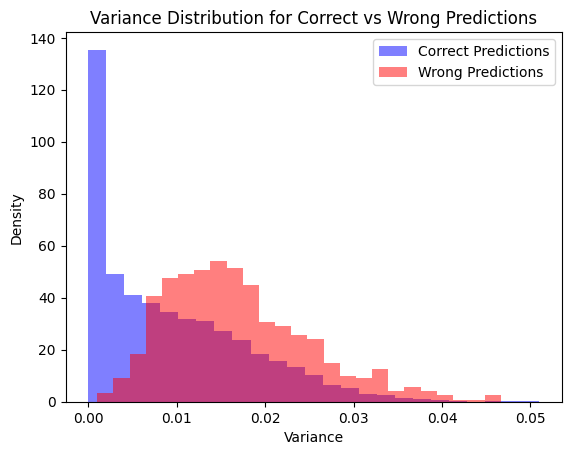

In [259]:
def distribution_variances_per_wrong_or_correct_prediction_normalized(var_vs_accuracy: Tensor):
    variances = var_vs_accuracy[:, 0].numpy()  # scalar values
    accuracies = var_vs_accuracy[:, 1].numpy()  # 0 or 1s

    fig, ax = plt.subplots()
    colors = ['blue', 'red']  # Colors for correct and wrong predictions
    labels = ['Correct Predictions', 'Wrong Predictions']

    for i, use_correct_predictions in enumerate([1., 0.]):
        indices = np.where(accuracies == use_correct_predictions)[0]
        variances_filtered = variances[indices]
        ax.hist(variances_filtered, bins=25, color=colors[i], alpha=0.5, label=labels[i], density=True)

    ax.set_xlabel("Variance")
    ax.set_ylabel("Density")
    ax.set_title("Variance Distribution for Correct vs Wrong Predictions")
    ax.legend()

    # Log the matplotlib figure to wandb
    # if options.use_wandb:
    #     wandb_section = get_wandb_audio_classific_key(opt, classifier_config)
    #     wandb.log({f"{wandb_section}_softmax/variance_distribution_combined": wandb.Image(fig)})

    plt.show()
    plt.close(fig)


distribution_variances_per_wrong_or_correct_prediction_normalized(res.detach())


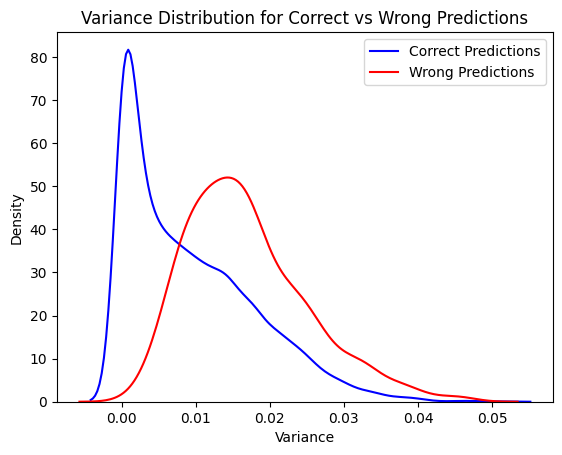

In [262]:
import seaborn as sns
def distribution_variances_per_wrong_or_correct_prediction_kde(var_vs_accuracy: Tensor):
    variances = var_vs_accuracy[:, 0].numpy()  # scalar values
    accuracies = var_vs_accuracy[:, 1].numpy()  # 0 or 1s

    fig, ax = plt.subplots()
    colors = ['blue', 'red']  # Colors for correct and wrong predictions
    labels = ['Correct Predictions', 'Wrong Predictions']

    for i, use_correct_predictions in enumerate([1., 0.]):
        indices = np.where(accuracies == use_correct_predictions)[0]
        variances_filtered = variances[indices]
        sns.kdeplot(variances_filtered, color=colors[i], label=labels[i])

    ax.set_xlabel("Variance")
    ax.set_ylabel("Density")
    ax.set_title("Variance Distribution for Correct vs Wrong Predictions")
    ax.legend()

    # Log the matplotlib figure to wandb
    # if options.use_wandb:
    #     wandb_section = get_wandb_audio_classific_key(opt, classifier_config)
    #     wandb.log({f"{wandb_section}_softmax/variance_distribution_combined": wandb.Image(fig)})

    plt.show()
    plt.close(fig)
    
distribution_variances_per_wrong_or_correct_prediction_kde(res.detach())

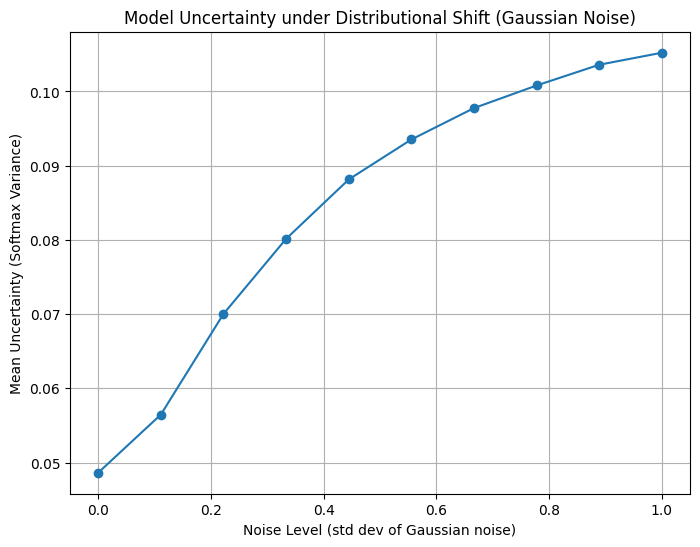

In [260]:
# Function to add Gaussian noise
def add_gaussian_noise(images, noise_factor):
    noisy_images = images + noise_factor * torch.randn(*images.shape)
    noisy_images = torch.clip(noisy_images, 0., 1.)
    return noisy_images


# Function to compute model's uncertainty (e.g., softmax variance)
def compute_uncertainty(outputs):  # outputs: (batch_size, num_classes)
    # Softmax the output to get probabilities
    probs = F.softmax(outputs, dim=1)

    # Compute variance (uncertainty) across the class probabilities
    uncertainty = probs.var(dim=1)
    return uncertainty


def plot_uncertainty_vs_noise_level(model, test_loader):
    model.eval()

    # List to store noise levels and corresponding uncertainty values
    noise_levels = np.linspace(0, 1, 10)
    mean_uncertainties = []

    for noise_factor in noise_levels:
        all_uncertainties = []

        for images, _ in test_loader:
            noisy_images = add_gaussian_noise(images, noise_factor)
            with torch.no_grad():
                outputs, _ = model(noisy_images)
                uncertainty = compute_uncertainty(outputs)
                all_uncertainties.append(uncertainty.mean().item())

        mean_uncertainties.append(np.mean(all_uncertainties))

    # Plotting the results
    plt.figure(figsize=(8, 6))
    plt.plot(noise_levels, mean_uncertainties, marker='o', linestyle='-')
    plt.title('Model Uncertainty under Distributional Shift (Gaussian Noise)')
    plt.xlabel('Noise Level (std dev of Gaussian noise)')
    plt.ylabel('Mean Uncertainty (Softmax Variance)')
    plt.grid(True)
    plt.show()


plot_uncertainty_vs_noise_level(c, val_loader)
